In [1]:
import math
import numpy as np
from numpy import zeros
from numpy import random
import matplotlib.pyplot as plt
#import pandas as pd
import pandas_datareader as web
import datetime as dt
from prettytable import PrettyTable

# Load Train Data
company = 'FB'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)
data = web.DataReader(company, 'yahoo', start, end)
training_data = np.array(data['Close'])
training_data = training_data.reshape(-1,1)

In [2]:
'''
Compare different activation function
'''

'''sigmoid'''
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def deltaSigmoid(y):
    return y * (1 - y)

'''tanh'''
def tanh(x):
    return math.tanh(x)

def deltaTanh(y):
    return 1.0 - y ** 2

'''ReLU'''
def ReLU(x):
    return np.maximum(x, 0)

def deltaReLU(y):
    return y > 0


'''Build neural network'''
class network:
    def __init__(self, inputs, hidden, outputs, activate_function='tanh'):
        # Initialize inputs as well as bias
        self.inputs = inputs

        # Initialize hidden units
        self.hidden = hidden

        # Initialize output units
        self.outputs = outputs
        
        # Initialize activation funvtion
        self.activate_fun = activate_function
        
        # Initialize activation for input nodes
        self.input_activations = [1.0] * self.inputs

        # Initialize activation for hidden units
        self.hidden_activations = [1.0] * self.hidden

        # Initialize activation for output units
        self.outputs_activations = [1.0] * self.outputs

        # Initialize weight matrix between inputs and hidden units
        self.input_weights = random.rand(self.inputs, self.hidden)

        # Initialize weight matrix between hidden units and outputs
        self.output_weights = random.rand(self.hidden, self.outputs)

        # Learning rate 
        self.lr = 0.1

        # Iterations epochs to train network
        self.epochs = 1000

    def forward(self, inputs):
        # Compute activation for all inputs except bias
        for input in range(self.inputs - 1):
            self.input_activations[input] = inputs[input]

        # Compute activation for all hidden units
        for hidden in range(self.hidden):
            sum = 0.0
            for input in range(self.inputs):
                sum += self.input_activations[input] * self.input_weights[input][hidden]
            if self.activate_fun == 'tanh':
                self.hidden_activations[hidden] = tanh(sum)
            elif self.activate_fun == 'sigmoid':
                self.hidden_activations[hidden] = sigmoid(sum)
            elif self.activate_fun == 'ReLU':
                self.hidden_activations[hidden] = ReLU(sum)

        # Compute activation for all output units
        for output in range(self.outputs):
            sum = 0.0
            for hidden in range(self.hidden):
                sum += self.hidden_activations[hidden] * self.output_weights[hidden][output]
            if self.activate_fun == 'tanh':
                self.outputs_activations[output] = tanh(sum)
            elif self.activate_fun == 'sigmoid':
                self.outputs_activations[output] = sigmoid(sum)
            elif self.activate_fun == 'ReLU':
                self.outputs_activations[output] = ReLU(sum)

        return self.outputs_activations

    def backpropagate(self, targets):
        # Compute error at output units
        output_deltas = [0.0] * self.outputs
        for output in range(self.outputs):
            error = targets[output] - self.outputs_activations[output]
            if self.activate_fun == 'tanh':
                output_deltas[output] = deltaTanh(self.outputs_activations[output]) * error
            elif self.activate_fun == 'sigmoid':
                output_deltas[output] = deltaSigmoid(self.outputs_activations[output]) * error
            elif self.activate_fun == 'ReLU':
                output_deltas[output] = deltaReLU(self.outputs_activations[output]) * error

        # Compute error at hidden units
        hidden_deltas = [0.0] * self.hidden
        for hidden in range(self.hidden):
            error = 0.0
            for output in range(self.outputs):
                error += output_deltas[output] * self.output_weights[hidden][output]
            if self.activate_fun == 'tanh':
                hidden_deltas[hidden] = deltaTanh(self.hidden_activations[hidden]) * error
            if self.activate_fun == 'sigmoid':
                hidden_deltas[hidden] = deltaSigmoid(self.hidden_activations[hidden]) * error
            if self.activate_fun == 'ReLU':
                hidden_deltas[hidden] = deltaReLU(self.hidden_activations[hidden]) * error

        # Update output unit weights
        for hidden in range(self.hidden):
            for output in range(self.outputs):
                update = output_deltas[output] * self.hidden_activations[hidden]
                self.output_weights[hidden][output] = self.output_weights[hidden][output] + self.lr * update

        # Update input unit weights
        for input in range(self.inputs):
            for hidden in range(self.hidden):
                update = hidden_deltas[hidden] * self.input_activations[input]
                self.input_weights[input][hidden] = self.input_weights[input][hidden] + self.lr * update

        # Compute total error
        error = 0.0
        for target in range(len(targets)):
            # Using MSE method to calculate loss
            error += 0.5 * (targets[target] - self.outputs_activations[target]) ** 2
        return error

    def test(self, pattern):
        # for pattern in patterns:
        self.forward(pattern)
        return self.forward(pattern)[0]

    def train(self, patterns):
        print("Activation function is: ", self.activate_fun)
        for epoch in range(self.epochs):
            loss = 0.0
            for pattern in patterns:
                inputs = pattern[0]
                targets = pattern[1]
                self.forward(inputs)
                loss += self.backpropagate(targets)
            if epoch % 50 == 0:
                print("Epoch %d loss: %.5f" % (epoch, loss))
        return format(loss, 'f')

In [3]:
'''prepare input data'''          
def average(data):
    sum = 0.0
    for datum in data:
        sum += datum
    return sum / len(data)

def maximum(data):
    return max(data)

def minimum(data):
    return min(data)

def normalize(price, minimum, maximum):
    return ((2 * price - (maximum + minimum)) / (maximum - minimum))

def denormalize(normalized, minimum, maximum):
    return (((normalized * (maximum-minimum)) / 2) + (maximum + minimum)) / 2

'''tain and test data'''
def run(training_data, test_data, prediction_days=60, activation_fun='tanh'):

    x_train = []
    y_train = []

    for x in range(prediction_days, len(training_data)):
        x_train.append(training_data[x - prediction_days:x,0]) # per past 60 days stock
        y_train.append(training_data[x, 0]) # the next day stock

    x_train, y_train = np.array(x_train), np.array(y_train)

  # Compute the average, minimum, maximum and normalized prices
    computed_x_data = []

    for i in range(len(x_train)):
        # Prepare [average, minimum, maximum]
        x_data = []
        ave = average(x_train[i])
        min = minimum(x_train[i])
        max = maximum(x_train[i])
        x_data.append(ave)
        x_data.append(min)
        x_data.append(max)
        computed_x_data.append(x_data)

        # Prepare normalized y value
        y_data = []
        y_data.append(normalize(y_train[i], min, max))
        computed_x_data.append(y_data)
    training_data = [computed_x_data]

    # Create network architecture consisting of 3 input nodes, 2 hidden units, and 1 output unit
    n = network(3, 2, 1, activation_fun)

    # Train the network
    loss = n.train(training_data)

    # Make Predictions on Test Data
    x_test = []
    y_test = []
    for x in range(prediction_days, len(test_data)):
        x_test.append(test_data[x - prediction_days:x,0])
        y_test.append(test_data[x,0])

    x_test, y_test = np.array(x_test), np.array(y_test)
    prediction_data = []
    y_pred = []

    # Compute x_test in the form of [average, minimum, maximum]
    for i in range(len(x_test)):
        data = []
        ave = average(x_test[i])
        min = minimum(x_test[i])
        max = maximum(x_test[i])
        data.append(ave)
        data.append(min)
        data.append(max)
        prediction_data.append(data)

    # Test the network
    for i in range(len(prediction_data)):
        value = n.test(prediction_data[i])
        y_pred.append(denormalize(value, prediction_data[i][1], prediction_data[i][2]))

    return y_pred, y_test, loss

Activation function is:  sigmoid
Epoch 0 loss: 1.64092
Epoch 50 loss: 0.69013
Epoch 100 loss: 0.53955
Epoch 150 loss: 0.50763
Epoch 200 loss: 0.49435
Epoch 250 loss: 0.48714
Epoch 300 loss: 0.48263
Epoch 350 loss: 0.47955
Epoch 400 loss: 0.47731
Epoch 450 loss: 0.47561
Epoch 500 loss: 0.47428
Epoch 550 loss: 0.47320
Epoch 600 loss: 0.47232
Epoch 650 loss: 0.47158
Epoch 700 loss: 0.47095
Epoch 750 loss: 0.47042
Epoch 800 loss: 0.46995
Epoch 850 loss: 0.46954
Epoch 900 loss: 0.46918
Epoch 950 loss: 0.46885


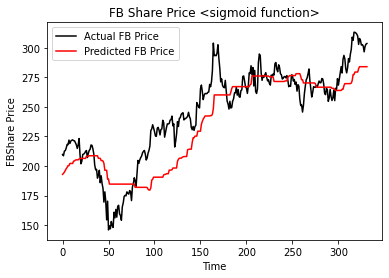

Activation function is:  tanh
Epoch 0 loss: 1.57559
Epoch 50 loss: 0.00607
Epoch 100 loss: 0.00213
Epoch 150 loss: 0.00113
Epoch 200 loss: 0.00071
Epoch 250 loss: 0.00048
Epoch 300 loss: 0.00035
Epoch 350 loss: 0.00026
Epoch 400 loss: 0.00020
Epoch 450 loss: 0.00016
Epoch 500 loss: 0.00013
Epoch 550 loss: 0.00010
Epoch 600 loss: 0.00008
Epoch 650 loss: 0.00007
Epoch 700 loss: 0.00006
Epoch 750 loss: 0.00005
Epoch 800 loss: 0.00004
Epoch 850 loss: 0.00004
Epoch 900 loss: 0.00003
Epoch 950 loss: 0.00003


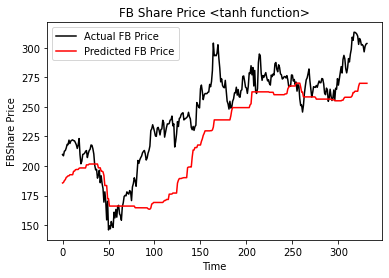

Activation function is:  ReLU
Epoch 0 loss: 1327.66119
Epoch 50 loss: 0.46332
Epoch 100 loss: 0.46332
Epoch 150 loss: 0.46332
Epoch 200 loss: 0.46332
Epoch 250 loss: 0.46332
Epoch 300 loss: 0.46332
Epoch 350 loss: 0.46332
Epoch 400 loss: 0.46332
Epoch 450 loss: 0.46332
Epoch 500 loss: 0.46332
Epoch 550 loss: 0.46332
Epoch 600 loss: 0.46332
Epoch 650 loss: 0.46332
Epoch 700 loss: 0.46332
Epoch 750 loss: 0.46332
Epoch 800 loss: 0.46332
Epoch 850 loss: 0.46332
Epoch 900 loss: 0.46332
Epoch 950 loss: 0.46332


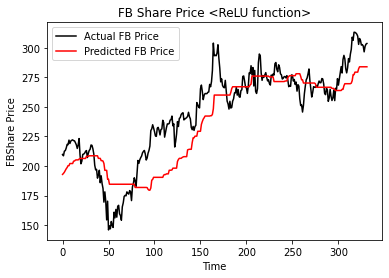

+---------------------+----------+
| Activation Function |   Loss   |
+---------------------+----------+
|       sigmoid       | 0.468569 |
|         tanh        | 0.000022 |
|         ReLU        | 0.463316 |
+---------------------+----------+


In [4]:
'''Predict real world Stock'''
# setting predict days range
predict_days = 60

# Load Test Data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()
data = web.DataReader(company, 'yahoo', test_start, test_end)
test_data = np.array(data['Close']).reshape(-1,1)
total_test_dataset = np.concatenate((training_data[-predict_days:], test_data), axis=0)

list_act_fun = ['sigmoid', 'tanh', 'ReLU']
list_loss = []
for function in list_act_fun:
    y_pred, y_test, loss= run(training_data, total_test_dataset,predict_days, function)
    list_loss.append(loss)
    '''Plot the Predicted Results'''
    # Plot the Test Predictions
    plt.plot(y_test, color='black', label=f'Actual {company} Price')
    plt.plot(y_pred, color='red', label=f'Predicted {company} Price')
    plt.title(f'{company} Share Price' f' <{function} function>')
    plt.xlabel('Time')
    plt.ylabel(f'{company}Share Price')
    plt.legend()
    plt.show()
    
    
t = PrettyTable(['Activation Function', 'Loss'])
for i in range(len(list_act_fun)):
    t.add_row([list_act_fun[i], list_loss[i]])
print(t)

The tanh has lowest loss error, thus this is the best activation function for stock prediction. 